In [60]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import os


In [ ]:
files = os.listdir('/Users/sunechristiansen/sune/network_analysis/project/parasites_network_analysis/projections_with_backbonings/projection_parasites/')

In [68]:
df = pd.read_csv('/Users/sunechristiansen/sune/network_analysis/project/parasites_network_analysis/projections_with_backbonings/projection_parasites/'+files[2])

df.rename(columns={'src': 'source', 'trg': 'target'}, inplace=True)
edges_list = df[['source', 'target']]
G = nx.from_pandas_edgelist(edges_list)
print(f'edges: {len(G.edges)}, nodes: {len(G.nodes)}')

edges: 598944, nodes: 17426


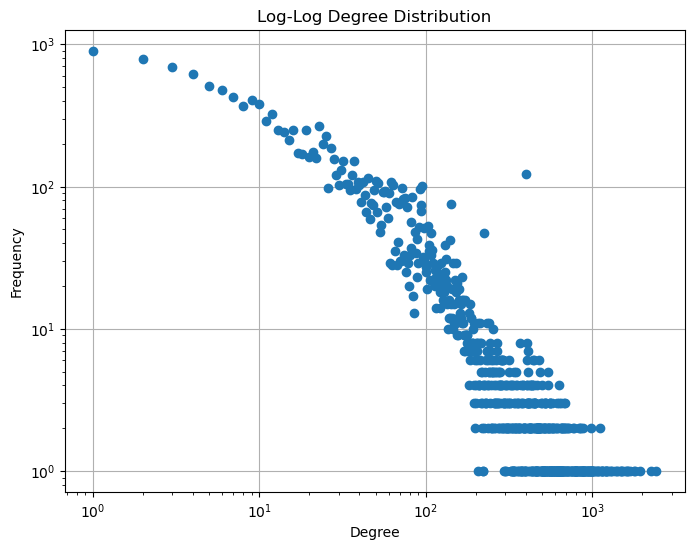

In [69]:

# Calculate degrees
degrees = [d for n, d in G.degree()]  # List of degrees for all nodes

# Count the frequency of each degree
degree_count = Counter(degrees)

# Sort degree and counts for plotting
degree, count = zip(*sorted(degree_count.items()))

# Plot the degree distribution
plt.figure(figsize=(8, 6))
plt.loglog(degree, count, marker="o", linestyle="")
plt.title("Log-Log Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
